In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-04 11:17:47.010813: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-04 11:17:47.809370: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-04 11:17:47.857033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-04 11:17:47.857082: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-04 11:17:47.861202: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-04 11:17:47.861267: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-04 11:17:47.863224: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

iawe_gen_GASF_60m_300S0X_R42_80-20


libcurand.so.10
2022-02-04 11:17:47.864422: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcutensor.so.1
2022-02-04 11:17:47.864999: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcusolver.so.11
2022-02-04 11:17:47.865849: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcusparse.so.11
2022-02-04 11:17:47.865984: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-04 11:17:47.866368: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['air conditioner', 'computer', 'fridge', 'television']
{0: 4.76595744680851, 1: 0.8265682656826568, 2: 0.43118383060635224, 3: 3.8290598290598292}
 
Tests 
air conditioner test: 23 train: 94
computer test: 136 train: 542
fridge test: 260 train: 1039
television test: 30 train: 117


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/iawe/TL/iawe_42_refit, eco, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data iawe training on model refit seed 42
reading data, printing stats: 
['air conditioner', 'computer', 'fridge', 'television']
{0: 4.76595744680851, 1: 0.8265682656826568, 2: 0.43118383060635224, 3: 3.8290598290598292}
 
Tests 
air conditioner test: 23 train: 94
computer test: 136 train: 542
fridge test: 260 train: 1039
television test: 30 train: 117
loading model
compling TL model..


2022-02-04 11:17:48.393646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-04 11:17:48.393976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-04 11:17:48.394031: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-04 11:17:48.766499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-04 11:17:48.766529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-04 11:17:48.766536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-04 11:17:48.767106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-04 11:17:49.327514: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-04 11:17:49.344431: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-04 11:17:49.826016: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-04 11:17:50.281861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-04 11:17:50.756488: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-04 11:17:51.163630: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


224/224 - 5s - loss: 0.8888 - accuracy: 0.7506
Epoch 2/50
224/224 - 4s - loss: 0.3963 - accuracy: 0.8281
Epoch 3/50
224/224 - 4s - loss: 0.2018 - accuracy: 0.8968
Epoch 4/50
224/224 - 4s - loss: 0.2051 - accuracy: 0.8901
Epoch 5/50
224/224 - 4s - loss: 0.1519 - accuracy: 0.9241
Epoch 6/50
224/224 - 3s - loss: 0.1237 - accuracy: 0.9342
Epoch 7/50
224/224 - 3s - loss: 0.1131 - accuracy: 0.9397
Epoch 8/50
224/224 - 4s - loss: 0.2054 - accuracy: 0.9235
Epoch 9/50
224/224 - 3s - loss: 0.2160 - accuracy: 0.9325
Epoch 10/50
224/224 - 3s - loss: 0.1339 - accuracy: 0.9196
Epoch 11/50
224/224 - 4s - loss: 0.0536 - accuracy: 0.9671
Epoch 12/50
224/224 - 4s - loss: 0.0668 - accuracy: 0.9704
Epoch 13/50
224/224 - 4s - loss: 0.0591 - accuracy: 0.9704
Epoch 14/50
224/224 - 4s - loss: 0.0901 - accuracy: 0.9554
Epoch 15/50
224/224 - 4s - loss: 0.0349 - accuracy: 0.9816
Epoch 16/50
224/224 - 4s - loss: 0.0163 - accuracy: 0.9916
Epoch 17/50
224/224 - 4s - loss: 0.0519 - accuracy: 0.9743
Epoch 18/50
224/2

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
224/224 - 4s - loss: 0.9091 - accuracy: 0.6551
Epoch 2/50
224/224 - 4s - loss: 1.0169 - accuracy: 0.7266
Epoch 3/50
224/224 - 4s - loss: 1.0398 - accuracy: 0.7863
Epoch 4/50
224/224 - 4s - loss: 0.3877 - accuracy: 0.8622
Epoch 5/50
224/224 - 4s - loss: 0.2735 - accuracy: 0.8962
Epoch 6/50
224/224 - 4s - loss: 0.2087 - accuracy: 0.9102
Epoch 7/50
224/224 - 4s - loss: 0.1702 - accuracy: 0.9258
Epoch 8/50
224/224 - 4s - loss: 0.2983 - accuracy: 0.9157
Epoch 9/50
224/224 - 4s - loss: 0.1318 - accuracy: 0.9453
Epoch 10/50
224/224 - 4s - loss: 0.1025 - accuracy: 0.9570
Epoch 11/50
224/224 - 3s - loss: 0.1320 - accuracy: 0.9358
Epoch 12/50
224/224 - 4s - loss: 0.1013 - accuracy: 0.9487
Epoch 13/50
224/224 - 3s - loss: 0.4483 - accuracy: 0.9180
Epoch 14/50
224/224 - 4s - loss: 0.7433 - accuracy: 0.8694
Epoch 15/50
224/224 - 4s - loss: 0.1796 - accuracy: 0.9247
Epoch 16/50
224/224 - 4s - loss: 0.1764 - accuracy: 0.9347
Epoch 17/50
224/224 - 4s - loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
224/224 - 4s - loss: 4.4435 - accuracy: 0.3298
Epoch 2/50
224/224 - 4s - loss: 1.0915 - accuracy: 0.5301
Epoch 3/50
224/224 - 4s - loss: 0.7599 - accuracy: 0.5848
Epoch 4/50
224/224 - 4s - loss: 0.7290 - accuracy: 0.6350
Epoch 5/50
224/224 - 4s - loss: 0.6578 - accuracy: 0.6652
Epoch 6/50
224/224 - 4s - loss: 0.7262 - accuracy: 0.7472
Epoch 7/50
224/224 - 4s - loss: 1.3840 - accuracy: 0.6657
Epoch 8/50
224/224 - 4s - loss: 0.7420 - accuracy: 0.6730
Epoch 9/50
224/224 - 4s - loss: 0.6599 - accuracy: 0.4743
Epoch 10/50
224/224 - 4s - loss: 0.6906 - accuracy: 0.4939
Epoch 11/50
224/224 - 4s - loss: 0.6698 - accuracy: 0.4866
Epoch 12/50
224/224 - 4s - loss: 0.6301 - accuracy: 0.4989
Epoch 13/50
224/224 - 4s - loss: 0.6286 - accuracy: 0.5140
Epoch 14/50
224/224 - 4s - loss: 0.5929 - accuracy: 0.5876
Epoch 15/50
224/224 - 4s - loss: 0.6033 - accuracy: 0.5290
Epoch 16/50
224/224 - 4s - loss: 0.6379 - accuracy: 0.5497
Epoch 17/50
224/224 - 3s - loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
224/224 - 4s - loss: 1.4795 - accuracy: 0.7863
Epoch 2/50
224/224 - 4s - loss: 0.4473 - accuracy: 0.8677
Epoch 3/50
224/224 - 4s - loss: 0.1770 - accuracy: 0.9191
Epoch 4/50
224/224 - 4s - loss: 0.1188 - accuracy: 0.9515
Epoch 5/50
224/224 - 4s - loss: 0.0974 - accuracy: 0.9643
Epoch 6/50
224/224 - 4s - loss: 0.0928 - accuracy: 0.9648
Epoch 7/50
224/224 - 4s - loss: 0.0756 - accuracy: 0.9654
Epoch 8/50
224/224 - 4s - loss: 0.0528 - accuracy: 0.9799
Epoch 9/50
224/224 - 4s - loss: 0.0754 - accuracy: 0.9637
Epoch 10/50
224/224 - 4s - loss: 0.0877 - accuracy: 0.9654
Epoch 11/50
224/224 - 4s - loss: 0.3978 - accuracy: 0.9224
Epoch 12/50
224/224 - 4s - loss: 0.1355 - accuracy: 0.9648
Epoch 13/50
224/224 - 4s - loss: 0.0522 - accuracy: 0.9743
Epoch 14/50
224/224 - 4s - loss: 0.1673 - accuracy: 0.9693
Epoch 15/50
224/224 - 4s - loss: 0.0680 - accuracy: 0.9816
Epoch 16/50
224/224 - 4s - loss: 0.0284 - accuracy: 0.9833
Epoch 17/50
224/224 - 3s - loss:

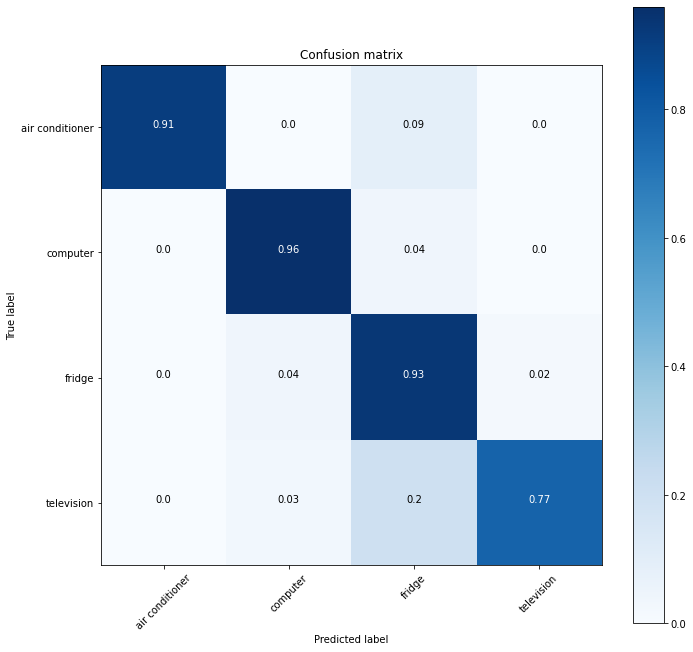

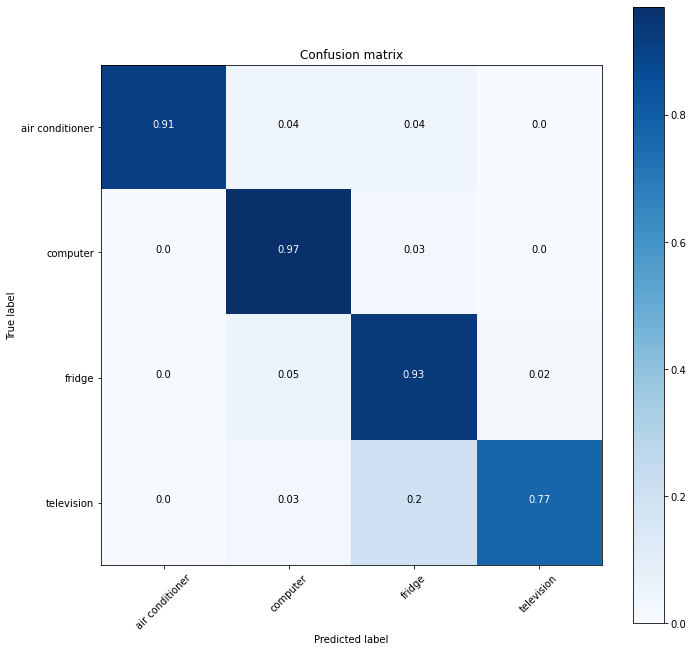

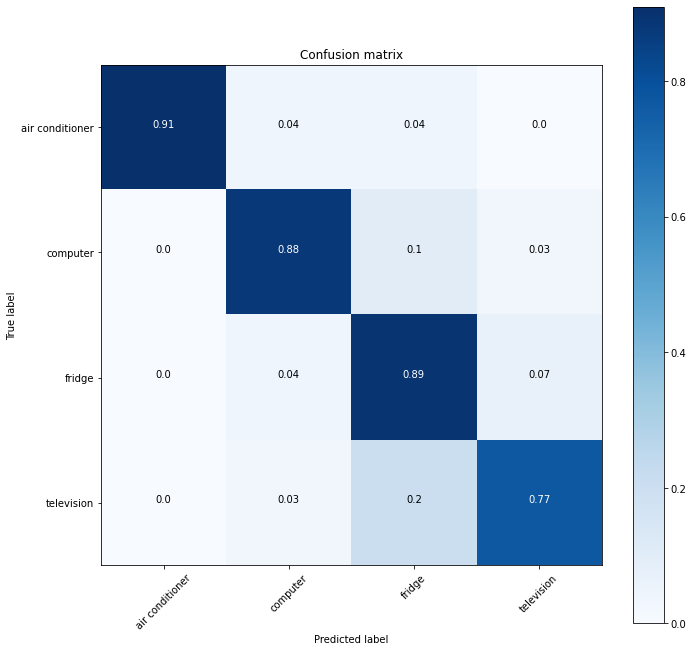

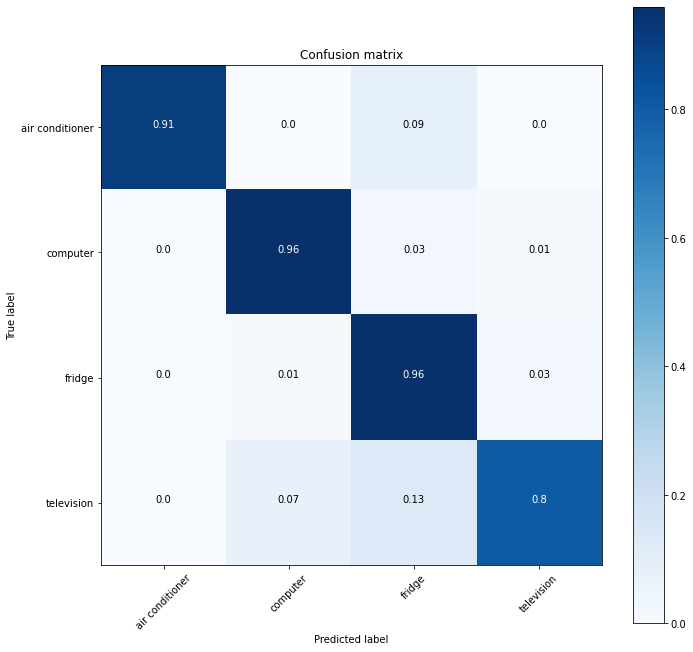

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()